### Imports

In [109]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### Extracting Data From CSVs

In [2]:
df_news = pd.read_csv('cryptonews.csv')
df_bitcoin = pd.read_csv('historical_bitcoin_data.csv')
df_trends = pd.read_csv('bitcoin_monthly_trends.csv')

# Exploratory Data Analysis

Here I explore the data in order to find out more about what I can observe, the different datatypes and where I can make transformations to the data.

In [3]:
print(df_news.dtypes)

date         object
sentiment    object
source       object
subject      object
text         object
title        object
url          object
dtype: object


In [4]:
# Check the dimensions of the DataFrame (rows, columns)
print(df_news.shape)

(18543, 7)


In [5]:
# Get an overview of the columns and their data types
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18543 entries, 0 to 18542
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       18543 non-null  object
 1   sentiment  18543 non-null  object
 2   source     18543 non-null  object
 3   subject    18543 non-null  object
 4   text       18543 non-null  object
 5   title      18543 non-null  object
 6   url        18543 non-null  object
dtypes: object(7)
memory usage: 1014.2+ KB


In [6]:
# Check for missing values
print(df_news.isnull().sum())

date         0
sentiment    0
source       0
subject      0
text         0
title        0
url          0
dtype: int64


In [7]:
duplicate_rows = df_news[df_news.duplicated()]
if duplicate_rows.empty:
    print("No duplicate values found in df_news")
else:
    print("Duplicate values found in df_news:")
    print(duplicate_rows)

No duplicate values found in df_news


In [8]:
df_news.head()

,date,sentiment,source,subject,text,title,url
0,2023-04-05 06:52:09,"{'class': 'negative', 'polarity': -0.03, 'subj...",CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
1,2023-04-05 06:19:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...
2,2023-04-05 05:09:44,"{'class': 'negative', 'polarity': -0.04, 'subj...",CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...
3,2023-04-05 01:09:52,"{'class': 'positive', 'polarity': 0.07, 'subje...",CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...
4,2023-04-04 23:49:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...


In [9]:
df_news.tail()

,date,sentiment,source,subject,text,title,url
18538,2021-10-27 15:17:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...
18539,2021-10-19 13:39:00,"{'class': 'positive', 'polarity': 0.1, 'subjec...",CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...
18540,2021-10-18 13:58:00,"{'class': 'positive', 'polarity': 0.14, 'subje...",CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...
18541,2021-10-15 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...
18542,2021-10-12 20:00:00,"{'class': 'positive', 'polarity': 0.16, 'subje...",CryptoNews,blockchain,"Within a little more than a year, Celo aims to...","Celo to Be Fastest EVM Chain by End of 2022, C...",https://cryptonews.com/news/celo-to-be-fastest...


In [10]:
# Compute basic summary statistics for numeric columns
df_news.describe()

,date,sentiment,source,subject,text,title,url
count,18543,18543,18543,18543,18543,18543,18543
unique,18304,3196,3,6,18131,18511,18543
top,2022-01-14 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,bitcoin,"Get your daily, bite-sized digest of cryptoass...",Is it Too Late to Buy Shiba Inu? Crypto Expert...,https://cointelegraph.com/news/opensea-to-enfo...
freq,26,4195,8675,6439,326,4,1


# EDA on bitcoin price data

In [11]:
print(df_bitcoin.dtypes)

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [12]:
# Check the dimensions of the DataFrame (rows, columns)
df_bitcoin.shape

(3800, 7)

In [13]:
# Check for missing values
print(df_bitcoin.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [14]:
duplicate_rows = df_bitcoin[df_bitcoin.duplicated()]
if duplicate_rows.empty:
    print("No duplicate values found in df_bitcoin")
else:
    print("Duplicate values found in df_bitcoin:")
    print(duplicate_rows)

No duplicate values found in df_bitcoin


In [15]:
df_bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 28, 2023","27,226.1","26,855.3","27,315.4","26,788.5",32.87K,1.37%
1,"May 27, 2023","26,857.5","26,711.2","26,882.9","26,591.2",18.68K,0.55%
2,"May 26, 2023","26,711.5","26,475.5","26,911.6","26,330.0",45.88K,0.89%
3,"May 25, 2023","26,475.8","26,327.1","26,589.2","25,892.5",50.17K,0.56%
4,"May 24, 2023","26,328.4","27,220.7","27,220.7","26,088.7",72.65K,-3.28%


In [16]:
df_bitcoin.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3795,"Jan 05, 2013",13.4,13.5,13.6,13.3,21.33K,-0.44%
3796,"Jan 04, 2013",13.5,13.4,13.5,13.3,29.64K,0.75%
3797,"Jan 03, 2013",13.4,13.3,13.5,13.3,18.03K,0.90%
3798,"Jan 02, 2013",13.3,13.3,13.4,13.2,17.97K,0.00%
3799,"Jan 01, 2013",13.3,13.5,13.6,13.2,28.41K,-1.55%


In [17]:
df_bitcoin.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,3800,3800,3800,3800,3800,3800,3800
unique,3800,3605,3598,3589,3602,3521,1387
top,"Sep 15, 2014",238.9,238.9,138.0,585.4,1.05M,0.00%
freq,1,4,4,4,4,6,17


# EDA on Google trends data

In [18]:
print(df_trends.dtypes)

date         object
Bitcoin       int64
isPartial      bool
dtype: object


In [19]:
# Check the dimensions of the DataFrame (rows, columns)
print(df_trends.shape)

(125, 3)


In [20]:
# Get an overview of the columns and their data types
df_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       125 non-null    object
 1   Bitcoin    125 non-null    int64 
 2   isPartial  125 non-null    bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 2.2+ KB


In [21]:
# Check for missing values
print(df_trends.isnull().sum())

date         0
Bitcoin      0
isPartial    0
dtype: int64


In [22]:
duplicate_rows = df_trends[df_trends.duplicated()]
if duplicate_rows.empty:
    print("No duplicate values found in df_trends")
else:
    print("Duplicate values found in df_trends:")
    print(duplicate_rows)

No duplicate values found in df_trends


In [23]:
df_trends.head()

,date,Bitcoin,isPartial
0,2013-01-01,1,False
1,2013-02-01,1,False
2,2013-03-01,3,False
3,2013-04-01,7,False
4,2013-05-01,3,False


In [24]:
df_trends.tail()

,date,Bitcoin,isPartial
120,2023-01-01,21,False
121,2023-02-01,19,False
122,2023-03-01,22,False
123,2023-04-01,21,False
124,2023-05-01,17,True


In [25]:
df_trends.describe()

,Bitcoin
count,125.000000
mean,16.112000
std,16.520865
min,1.000000
25%,3.000000
50%,12.000000
75%,21.000000
max,100.000000


<AxesSubplot:title={'center':'Bitcoin Search Interest Over Time'}, xlabel='date'>

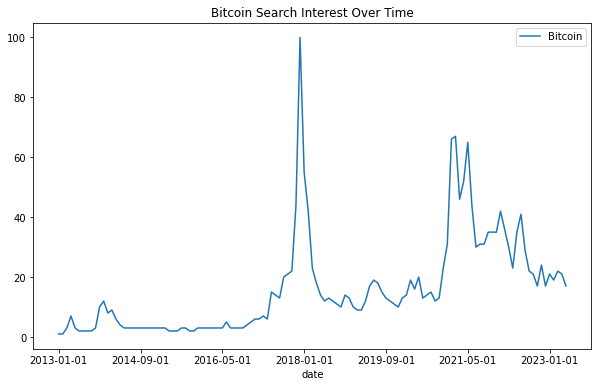

In [26]:
df_trends.plot(x='date', y='Bitcoin', figsize=(10, 6), title='Bitcoin Search Interest Over Time')


# Transforming news dataframe

In [27]:
#df_news.drop('sentiment', axis = 1, inplace=True)
df_news.columns

Index(['date', 'sentiment', 'source', 'subject', 'text', 'title', 'url'], dtype='object')

In [28]:
df_bitcoin.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [29]:
df_trends.columns

Index(['date', 'Bitcoin', 'isPartial'], dtype='object')

In [30]:
df_news = df_news.rename(columns={'text': 'Article Summary', 'date': 'Date'})
df_trends = df_trends.rename(columns={'Bitcoin': 'Score', 'isPartial': 'Month Incomplete', 'date': 'Date'})


In [31]:
unique_vol_values = df_bitcoin['Vol.'].unique()
print(unique_vol_values)

['32.87K' '18.68K' '45.88K' ... '29.64K' '18.03K' '17.97K']


In [32]:
# Convert date column to datetime format
df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date']).dt.floor('D')
df_news['Date'] = pd.to_datetime(df_news['Date']).dt.floor('D')
df_trends['Date'] = pd.to_datetime(df_trends['Date']).dt.floor('D')

# Convert numerical columns to floats

# String manipulations
df_bitcoin['Price'] = df_bitcoin['Price'].str.replace(',', '').astype(float)
df_bitcoin['Open'] = df_bitcoin['Open'].str.replace(',', '').astype(float)
df_bitcoin['High'] = df_bitcoin['High'].str.replace(',', '').astype(float)
df_bitcoin['Low'] = df_bitcoin['Low'].str.replace(',', '').astype(float)

def convert_volume(value):
    value = re.sub(r'[^\d.]', '', value)  # Remove non-numeric characters
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    else:
        return float(value)

df_bitcoin['Vol.'] = df_bitcoin['Vol.'].apply(convert_volume)
# Remove the percentage sign
df_bitcoin['Change %'] = df_bitcoin['Change %'].str.rstrip('%')

# Convert the column to float
df_bitcoin['Price'] = df_bitcoin['Price'].astype(float)
df_bitcoin['Open'] = df_bitcoin['Open'].astype(float)
df_bitcoin['High'] = df_bitcoin['High'].astype(float)
df_bitcoin['Low'] = df_bitcoin['Low'].astype(float)
df_bitcoin['Vol.'] = df_bitcoin['Vol.'].astype(float)
df_bitcoin['Change %'] = df_bitcoin['Change %'].astype(float)



In [33]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3800 non-null   datetime64[ns]
 1   Price     3800 non-null   float64       
 2   Open      3800 non-null   float64       
 3   High      3800 non-null   float64       
 4   Low       3800 non-null   float64       
 5   Vol.      3800 non-null   float64       
 6   Change %  3800 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 207.9 KB


In [34]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18543 entries, 0 to 18542
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             18543 non-null  datetime64[ns]
 1   sentiment        18543 non-null  object        
 2   source           18543 non-null  object        
 3   subject          18543 non-null  object        
 4   Article Summary  18543 non-null  object        
 5   title            18543 non-null  object        
 6   url              18543 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 1014.2+ KB


In [35]:
df_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              125 non-null    datetime64[ns]
 1   Score             125 non-null    int64         
 2   Month Incomplete  125 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 2.2 KB


In [36]:
df_trends.drop('Month Incomplete', axis = 1, inplace = True)
df_news.drop('sentiment', axis = 1, inplace = True)

## Feature Engineering

In [37]:
#Engineering a new feature, percentage increase between months in df_trends
# Sort the DataFrame by the "Date" column in ascending order
df_trends.sort_values('Date', inplace=True)

# Calculate the percentage increase of the trend score
df_trends['Trend Increase'] = df_trends['Score'].pct_change() * 100

# Drop the first row since it will have a NaN value
#df_trends.dropna(subset=['Trend Increase'], inplace=True)

# Round the values to two decimal places
df_trends['Trend Increase'] = df_trends['Trend Increase'].round(2)
df_trends.head()

,Date,Score,Trend Increase
0,2013-01-01,1,NaN
1,2013-02-01,1,0.00
2,2013-03-01,3,200.00
3,2013-04-01,7,133.33
4,2013-05-01,3,-57.14


In [38]:
#feature engineering a sentiment analysis column in df_news
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

for index, row in df_news.iterrows():
    title = row['title']
    summary = row['Article Summary']

    title_sentiment = sia.polarity_scores(title)
    summary_sentiment = sia.polarity_scores(summary)

    df_news.at[index, 'Title Sentiment'] = title_sentiment['compound']
    df_news.at[index, 'Summary Sentiment'] = summary_sentiment['compound']
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\OsmanAbdulrazak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
df_news.tail()

,Date,source,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment
18538,2021-10-27,CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,-0.8020,-0.743
18539,2021-10-19,CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,0.0000,0.000
18540,2021-10-18,CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,0.0000,0.000
18541,2021-10-15,CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0.4215,0.000
18542,2021-10-12,CryptoNews,blockchain,"Within a little more than a year, Celo aims to...","Celo to Be Fastest EVM Chain by End of 2022, C...",https://cryptonews.com/news/celo-to-be-fastest...,0.0000,0.000


In [40]:
df_bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-05-28,27226.1,26855.3,27315.4,26788.5,32.87,1.37
1,2023-05-27,26857.5,26711.2,26882.9,26591.2,18.68,0.55
2,2023-05-26,26711.5,26475.5,26911.6,26330.0,45.88,0.89
3,2023-05-25,26475.8,26327.1,26589.2,25892.5,50.17,0.56
4,2023-05-24,26328.4,27220.7,27220.7,26088.7,72.65,-3.28


In [41]:
#generating date components, this will be to undergo temporal, seasonality, and day of the week analysis, as well as data grouping

df_bitcoin['Year'] = df_bitcoin['Date'].dt.year
df_bitcoin['Month'] = df_bitcoin['Date'].dt.month
df_bitcoin['Day'] = df_bitcoin['Date'].dt.day
df_bitcoin['DayOfWeek'] = df_bitcoin['Date'].dt.dayofweek
df_bitcoin['DayName'] = df_bitcoin['Date'].dt.day_name()
df_bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,DayName
0,2023-05-28,27226.1,26855.3,27315.4,26788.5,32.87,1.37,2023,5,28,6,Sunday
1,2023-05-27,26857.5,26711.2,26882.9,26591.2,18.68,0.55,2023,5,27,5,Saturday
2,2023-05-26,26711.5,26475.5,26911.6,26330.0,45.88,0.89,2023,5,26,4,Friday
3,2023-05-25,26475.8,26327.1,26589.2,25892.5,50.17,0.56,2023,5,25,3,Thursday
4,2023-05-24,26328.4,27220.7,27220.7,26088.7,72.65,-3.28,2023,5,24,2,Wednesday


In [42]:
df_news['Year'] = df_news['Date'].dt.year
df_news['Month'] = df_news['Date'].dt.month
df_news['Day'] = df_news['Date'].dt.day
df_news['DayOfWeek'] = df_news['Date'].dt.dayofweek
df_news['DayName'] = df_news['Date'].dt.day_name()
df_news.head()

,Date,source,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment,Year,Month,Day,DayOfWeek,DayName
0,2023-04-05,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...,-0.25,0.0000,2023,4,5,2,Wednesday
1,2023-04-05,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...,0.00,0.0000,2023,4,5,2,Wednesday
2,2023-04-05,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...,0.00,-0.4767,2023,4,5,2,Wednesday
3,2023-04-05,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...,0.00,0.0000,2023,4,5,2,Wednesday
4,2023-04-04,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...,0.00,0.0000,2023,4,4,1,Tuesday


In [43]:
df_trends['Year'] = df_trends['Date'].dt.year
df_trends['Month'] = df_trends['Date'].dt.month
df_trends.head()

,Date,Score,Trend Increase,Year,Month
0,2013-01-01,1,NaN,2013,1
1,2013-02-01,1,0.00,2013,2
2,2013-03-01,3,200.00,2013,3
3,2013-04-01,7,133.33,2013,4
4,2013-05-01,3,-57.14,2013,5


In [44]:
#aggregations based on date


# Perform monthly aggregation
df_bitcoin_monthly = df_bitcoin.groupby(['Year','Month']).agg({
    'Price': 'mean',  # Calculate the average price for each year
    'Vol.': 'sum'  # Calculate the total volume for each year
}).reset_index()

df_bitcoin_monthly.head()

,Year,Month,Price,Vol.
0,2013,1,15.600000,1455.21
1,2013,2,26.042857,1584.31
2,2013,3,57.503226,2115.44
3,2013,4,130.340000,4731.87
4,2013,5,119.967742,2071.79


In [45]:
# Perform monthly aggregation on news sentiment
df_news_monthly = df_news.groupby(['Year', 'Month', 'Date']).agg({
    'Title Sentiment': 'mean',  # Calculate the average sentiment score for each month
    'Summary Sentiment': 'mean'  # Calculate the average sentiment score for each month
}).reset_index()

df_news_monthly.head()

,Year,Month,Date,Title Sentiment,Summary Sentiment
0,2021,10,2021-10-12,0.0000,0.000
1,2021,10,2021-10-15,0.4215,0.000
2,2021,10,2021-10-18,0.0000,0.000
3,2021,10,2021-10-19,0.0000,0.000
4,2021,10,2021-10-27,-0.8020,-0.743


In [46]:
# Merge df_bitcoin, df_news, and df_trends based on 'Date'
merged_df = pd.merge(df_bitcoin, df_news, on='Date', how='inner')
merged_df = pd.merge(merged_df, df_trends, on='Date', how='inner')

merged_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Year_x',
       'Month_x', 'Day_x', 'DayOfWeek_x', 'DayName_x', 'source', 'subject',
       'Article Summary', 'title', 'url', 'Title Sentiment',
       'Summary Sentiment', 'Year_y', 'Month_y', 'Day_y', 'DayOfWeek_y',
       'DayName_y', 'Score', 'Trend Increase', 'Year', 'Month'],
      dtype='object')

In [47]:
# Drop duplicate columns
columns_to_drop = ['Year_y', 'Month_y', 'Day_y', 'DayOfWeek_y', 'DayName_y']
merged_df.drop(columns=columns_to_drop, inplace=True)

In [48]:
merged_df.rename(columns={'Year_x': 'Year', 'Month_x': 'Month', 'Day_x': 'Day', 'DayOfWeek_x': 'DayOfWeek', 'DayName_x': 'DayName'}, inplace=True)

merged_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Year',
       'Month', 'Day', 'DayOfWeek', 'DayName', 'source', 'subject',
       'Article Summary', 'title', 'url', 'Title Sentiment',
       'Summary Sentiment', 'Score', 'Trend Increase', 'Year', 'Month'],
      dtype='object')

In [49]:
merged_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,...,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment,Score,Trend Increase,Year,Month
0,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,blockchain,Flybondi started issuing flight tickets as NFT...,Argentinean Airline Becomes the First to Offer...,https://cryptopotato.com/argentinean-airline-b...,0.0000,0.0000,21,-4.55,2023,4
1,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,ethereum,The license expiration marks a significant eve...,Uniswap v3 code free to fork as BSL expires,https://cointelegraph.com/news/uniswap-v3-code...,0.5106,0.2023,21,-4.55,2023,4
2,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,altcoin,Brian Armstrong has argued against hitting a p...,Coinbase CEO Thinks Stopping ChatGPT Developme...,https://cryptopotato.com/coinbase-ceo-thinks-s...,-0.1531,-0.3612,21,-4.55,2023,4
3,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,altcoin,As the cryptocurrency market continues to expe...,Bitcoin Price Prediction as BTC Bulls Hold $28...,https://cryptonews.com/news/bitcoin-price-pred...,0.0000,0.8689,21,-4.55,2023,4
4,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,nft,Blur’s impressive rise to dominance has change...,NFT Market Hit $4.7B in Sales in Q1: DappRadar,https://cryptopotato.com/nft-market-hit-4-7b-i...,0.0000,0.6124,21,-4.55,2023,4


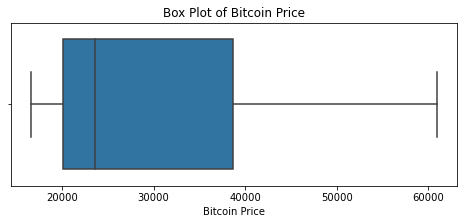

In [50]:
# Identifying outliers

#Calculating IQR
Q1 = merged_df['Price'].quantile(0.25)
Q3 = merged_df['Price'].quantile(0.75)
IQR = Q3 - Q1

#Defining the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Identifying outliers
outliers = merged_df[(merged_df['Price'] < lower_bound) | (merged_df['Price'] > upper_bound)]

plt.figure(figsize=(8, 3))
sns.boxplot(x=merged_df['Price'])
plt.title('Box Plot of Bitcoin Price')
plt.xlabel('Bitcoin Price')
plt.show()

#Shows there are no outliers in the data

In [51]:
merged_df.to_csv('Bitcoin_news_trends.csv')

In [52]:
df = pd.read_csv('Bitcoin_news_trends.csv')


# Data Analysis

In [53]:
df.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,...,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment,Score,Trend Increase,Year.1,Month.1
0,0,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,blockchain,Flybondi started issuing flight tickets as NFT...,Argentinean Airline Becomes the First to Offer...,https://cryptopotato.com/argentinean-airline-b...,0.0000,0.0000,21,-4.55,2023,4
1,1,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,ethereum,The license expiration marks a significant eve...,Uniswap v3 code free to fork as BSL expires,https://cointelegraph.com/news/uniswap-v3-code...,0.5106,0.2023,21,-4.55,2023,4
2,2,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,altcoin,Brian Armstrong has argued against hitting a p...,Coinbase CEO Thinks Stopping ChatGPT Developme...,https://cryptopotato.com/coinbase-ceo-thinks-s...,-0.1531,-0.3612,21,-4.55,2023,4
3,3,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,altcoin,As the cryptocurrency market continues to expe...,Bitcoin Price Prediction as BTC Bulls Hold $28...,https://cryptonews.com/news/bitcoin-price-pred...,0.0000,0.8689,21,-4.55,2023,4
4,4,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,nft,Blur’s impressive rise to dominance has change...,NFT Market Hit $4.7B in Sales in Q1: DappRadar,https://cryptopotato.com/nft-market-hit-4-7b-i...,0.0000,0.6124,21,-4.55,2023,4


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         601 non-null    int64  
 1   Date               601 non-null    object 
 2   Price              601 non-null    float64
 3   Open               601 non-null    float64
 4   High               601 non-null    float64
 5   Low                601 non-null    float64
 6   Vol.               601 non-null    float64
 7   Change %           601 non-null    float64
 8   Year               601 non-null    int64  
 9   Month              601 non-null    int64  
 10  Day                601 non-null    int64  
 11  DayOfWeek          601 non-null    int64  
 12  DayName            601 non-null    object 
 13  source             601 non-null    object 
 14  subject            601 non-null    object 
 15  Article Summary    601 non-null    object 
 16  title              601 non

In [55]:
df.shape

(601, 24)

In [56]:
df.describe()

,Unnamed: 0,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Title Sentiment,Summary Sentiment,Score,Trend Increase,Year.1,Month.1
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.0,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,300.000000,28101.708985,28062.650083,28672.130616,27439.060899,231.941980,-0.088319,2022.207987,5.913478,1.0,2.427621,0.036800,0.107796,26.136439,-5.150715,2022.207987,5.913478
std,173.638033,9973.652178,9679.782052,10038.157572,9515.560493,150.857172,2.602403,0.414330,3.393990,0.0,1.519376,0.316016,0.361124,7.420783,22.671185,0.414330,3.393990
min,0.000000,16618.400000,16537.500000,16621.900000,16499.700000,31.240000,-6.270000,2021.000000,1.000000,1.0,0.000000,-0.817600,-0.877900,17.000000,-29.270000,2021.000000,1.000000
25%,150.000000,20126.100000,20049.900000,20676.600000,19584.400000,135.090000,-1.120000,2022.000000,3.000000,1.0,1.000000,0.000000,0.000000,21.000000,-23.330000,2022.000000,3.000000
50%,300.000000,23642.200000,23130.600000,23784.500000,22863.800000,173.910000,0.410000,2022.000000,6.000000,1.0,2.000000,0.000000,0.000000,23.000000,-14.290000,2022.000000,6.000000
75%,450.000000,38709.700000,38475.600000,39230.000000,38037.900000,302.720000,2.210000,2022.000000,9.000000,1.0,4.000000,0.226300,0.381800,30.000000,15.790000,2022.000000,9.000000
max,600.000000,60915.300000,61310.100000,62430.100000,59612.700000,632.930000,3.290000,2023.000000,12.000000,1.0,6.000000,0.848100,0.920900,42.000000,52.170000,2023.000000,12.000000


In [57]:
df.corr()

,Unnamed: 0,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Title Sentiment,Summary Sentiment,Score,Trend Increase,Year.1,Month.1
Unnamed: 0,1.000000,0.736345,0.758319,0.755270,0.743797,-0.234996,-0.128410,-0.711160,-0.247806,NaN,-0.139697,-0.034283,-0.040778,0.715717,-0.210054,-0.711160,-0.247806
Price,0.736345,1.000000,0.997038,0.997968,0.999480,0.068354,0.319631,-0.231890,-0.595855,NaN,-0.079207,-0.008618,-0.038775,0.488288,-0.064487,-0.231890,-0.595855
Open,0.758319,0.997038,1.000000,0.999414,0.997847,0.044976,0.247635,-0.260462,-0.582020,NaN,-0.078780,-0.009863,-0.040362,0.538542,-0.055366,-0.260462,-0.582020
High,0.755270,0.997968,0.999414,1.000000,0.998228,0.047534,0.263166,-0.250717,-0.592291,NaN,-0.074602,-0.009308,-0.040446,0.531378,-0.062952,-0.250717,-0.592291
Low,0.743797,0.999480,0.997847,0.998228,1.000000,0.044155,0.303600,-0.241525,-0.590940,NaN,-0.085436,-0.008675,-0.037215,0.506174,-0.056912,-0.241525,-0.590940
Vol.,-0.234996,0.068354,0.044976,0.047534,0.044155,1.000000,0.331663,0.159888,0.057547,NaN,0.247103,-0.016632,-0.037341,-0.488652,0.039952,0.159888,0.057547
Change %,-0.128410,0.319631,0.247635,0.263166,0.303600,0.331663,1.000000,0.397309,-0.408211,NaN,-0.097471,0.029540,0.027390,-0.472655,-0.027522,0.397309,-0.408211
Year,-0.711160,-0.231890,-0.260462,-0.250717,-0.241525,0.159888,0.397309,1.000000,-0.500373,NaN,0.078227,0.075445,0.042544,-0.385981,0.194157,1.000000,-0.500373
Month,-0.247806,-0.595855,-0.582020,-0.592291,-0.590940,0.057547,-0.408211,-0.500373,1.000000,NaN,0.056313,-0.061520,-0.008569,-0.332784,0.013163,-0.500373,1.000000
Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Visualisations

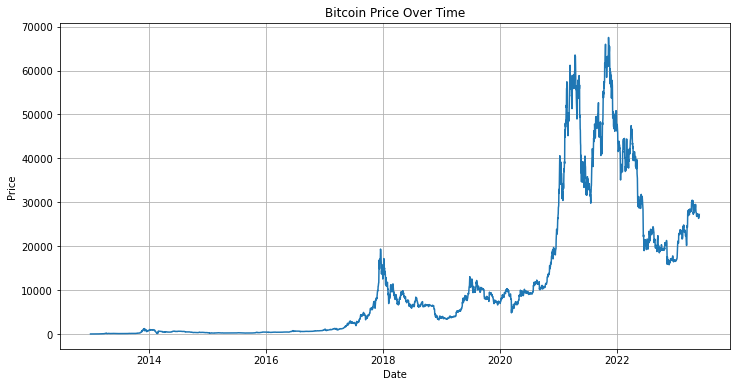

In [58]:
# Line chart for Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(df_bitcoin['Date'], df_bitcoin['Price'])
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

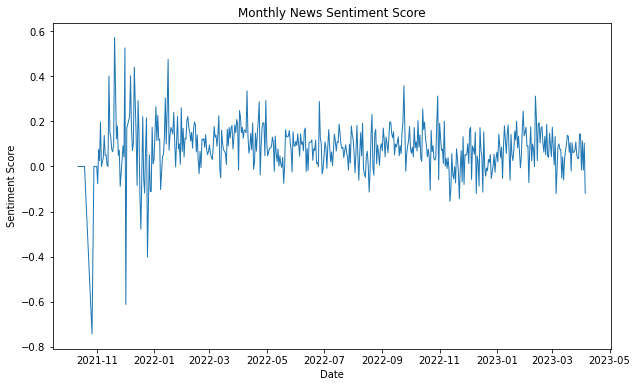

In [59]:
# Line chart for News sentiment
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the sentiment scores
plt.plot(df_news_monthly['Date'], df_news_monthly['Summary Sentiment'], linewidth=1)

# Customize the chart
plt.title('Monthly News Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')

# Display the chart
plt.show()

In [60]:
df_news_monthly.head()

,Year,Month,Date,Title Sentiment,Summary Sentiment
0,2021,10,2021-10-12,0.0000,0.000
1,2021,10,2021-10-15,0.4215,0.000
2,2021,10,2021-10-18,0.0000,0.000
3,2021,10,2021-10-19,0.0000,0.000
4,2021,10,2021-10-27,-0.8020,-0.743


## Visualisations for the relationship between Bitcoin prices and news sentiment over time

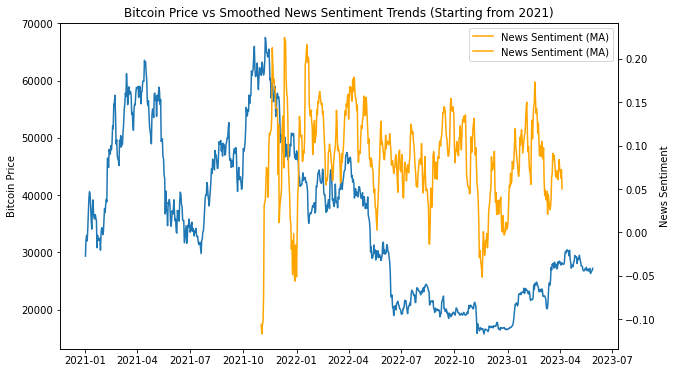

In [87]:
# Filter the dataframes to include only rows from 2021 onwards
df_bitcoin_filtered = df_bitcoin[df_bitcoin['Date'].dt.year >= 2021]
df_news_filtered = df_news_monthly[df_news_monthly['Date'].dt.year >= 2021]

# Set the figure size
plt.figure(figsize=(10, 6))

# Calculate the 7-day moving average of News Sentiment
window = 7
df_news_filtered['Sentiment_MA'] = df_news_filtered['Summary Sentiment'].rolling(window).mean()

# Plot Bitcoin prices
plt.plot(df_bitcoin_filtered['Date'], df_bitcoin_filtered['Price'], label='Bitcoin Price')
plt.ylabel('Bitcoin Price')

# Create a secondary y-axis for News Sentiment
ax2 = plt.twinx()
ax2.plot(df_news_filtered['Date'], df_news_filtered['Sentiment_MA'], color='orange', label='News Sentiment (MA)')
ax2.set_ylabel('News Sentiment')

# Customize the chart
plt.title('Bitcoin Price vs Smoothed News Sentiment Trends (Starting from 2021)')
plt.xlabel('Date')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Get the handles and labels for both lines
handles1, labels1 = plt.gca().get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine the handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create the legend
plt.legend(handles, labels)

# Display the chart
plt.show()


<ipython-input-89-8f273e8f2cd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bitcoin_filtered['Price_Pct_Change'] = df_bitcoin_filtered['Price'].pct_change() * 100


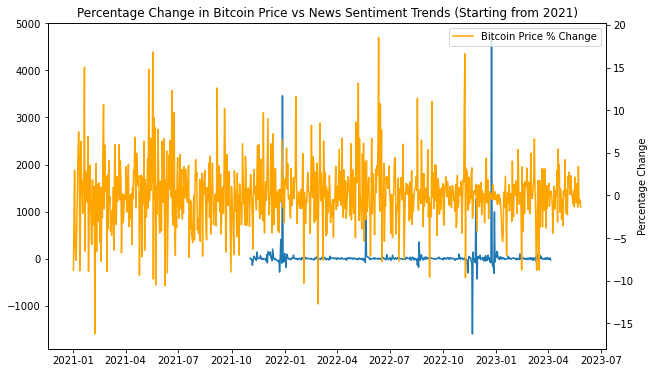

In [89]:
# Calculate the percentage change for Bitcoin Price
df_bitcoin_filtered['Price_Pct_Change'] = df_bitcoin_filtered['Price'].pct_change() * 100

# Calculate the percentage change for News Sentiment
df_news_filtered['Sentiment_Pct_Change'] = df_news_filtered['Sentiment_MA'].pct_change() * 100

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the percentage changes
plt.plot(df_news_filtered['Date'], df_news_filtered['Sentiment_Pct_Change'], label='News Sentiment % Change')
plt.twinx()  # Create a secondary y-axis
plt.plot(df_bitcoin_filtered['Date'], df_bitcoin_filtered['Price_Pct_Change'], label='Bitcoin Price % Change', color='orange')

# Customize the chart
plt.title('Percentage Change in Bitcoin Price vs News Sentiment Trends (Starting from 2021)')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.xticks(rotation=45)
plt.legend()

# Display the chart
plt.show()


# Visualisations for the relationship between Bitcoin prices and Google trends over time

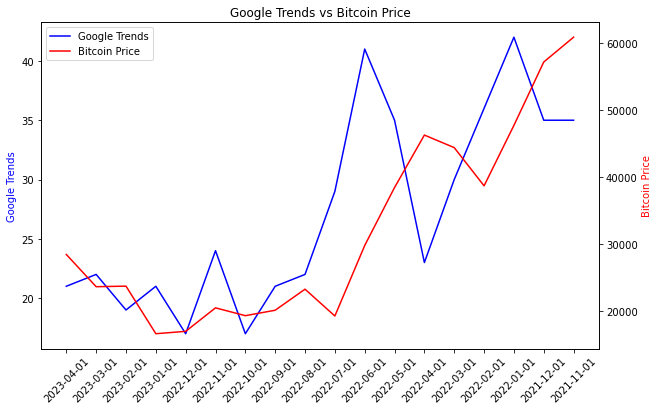

In [98]:
# Set the figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Google Trends data
ax1.plot(df['Date'], df['Score'], color='blue', label='Google Trends')
ax1.set_ylabel('Google Trends', color='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot Bitcoin prices
ax2.plot(df['Date'], df['Price'], color='red', label='Bitcoin Price')
ax2.set_ylabel('Bitcoin Price', color='red')

# Customize the chart
plt.title('Google Trends vs Bitcoin Price')
plt.xlabel('Date')

# Rotate the x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.setp(ax2.get_xticklabels(), rotation=45)

# Display the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Display the chart
plt.show()

# Modelling

#### Steps to create the model

1. Selecting the relevant feature and target variable from the df dataframe. Here I've selected the 'Score' and the 'Price' column to see if Google trends can accurately predict the price of Bitcoin.

2. Next I split the data into training and testing sets using the 'train_test_split' function from scikit-learn. This is an important step to be able to evaluate the model's performance on unseen data rather than the data it has been trained on. Here I used an 80/20 split to

3. Initialize a machine learning model. In this example, I used the 'LinearRegression' model from scikit-learn. I chose this because it is suitable for predicting continuous numerical values such as Bitcoin prices. I then train the model.

4. Finally I evaluate the model on several metrics: mean squared error (MSE), root mean squared error (RMSE), and R-squared (R2). This is done by calling the predict method with the testing set.


In [104]:
# Data Preparation
model_df = df[['Date', 'Score', 'Price']].copy()
model_df.dropna(inplace=True)  # Remove rows with missing values
model_df.reset_index(drop=True, inplace=True)
features = model_df['Score'].values.reshape(-1, 1)
target = model_df['Price'].values

In [105]:
# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [106]:
# Model Selection
model = LinearRegression()

# Model Training
model.fit(X_train, y_train)


LinearRegression()

In [107]:
# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [108]:
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 59507853.525687195
Root Mean Squared Error (RMSE): 7714.133361932965
R-squared (R2) Score: 0.3627627141999602


### Evaluation

The RMSE shows that on average the model makes predictions that are off by approximately $7714.

The R2 score suggests that the model explains 36% of the variance in the Bitcoin prices.

Next I will try using the 'RandomForestRegressor' model. Linear regression assumes a linear relationship between the input input and target features, I felt it would be useful to use a random forest regressor to try to capture non-linear relationships between the features.

I also adopted the use of Grid Search in otder to find the optimal combination of hyperparameters for the model in order to yield the best results.

In [110]:
rf_model = RandomForestRegressor()

In [111]:
# Define the hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [112]:
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [113]:
# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [114]:
# Fit the model on the training data
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5)

In [115]:
# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

In [116]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [117]:
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 5907760.525404785
Root Mean Squared Error (RMSE): 2430.5885142090146
R-squared (R2) Score: 0.9367370009281125


The Mean Squared Error (MSE) has decreased from 59,507,853 to 5,907,760. This indicates that, on average, the predicted values are closer to the actual values compared to the previous model.

The Root Mean Squared Error (RMSE) has decreased from 7,714.13 to 2,430.59. This indicates that, on average, the predicted values have a smaller deviation from the actual values, which is a substantial improvement.

The R-squared (R2) score has increased from 0.36 to 0.94. This score represents the proportion of variance in the target variable (Bitcoin price) that is explained by the model. A higher R2 score closer to 1 indicates a better fit of the model to the data.